<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imagenes de resonancia magnetica, mediante red neuronal convolucional CNN </h2> 
</span>

## Instalar librerías

In [ ]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
!pip install tf-nightly

In [ ]:
!pip install h5py

In [ ]:
!pip install scikit-learn

In [ ]:
!pip uninstall tensorflow-directml

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [115]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

## Importar librerías

In [116]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
 
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import numpy as np
from sklearn.metrics import plot_confusion_matrix

import os.path
from tensorflow.keras import Model, optimizers
from tensorflow.keras.applications import xception
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

## Configurar GPU con TensorFlow

In [117]:
tensorflow.test.is_gpu_available()
print("Num GPUs available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

print(tensorflow.test.gpu_device_name())
print(tensorflow.test.is_gpu_available())

Num GPUs available 0
/device:DML:0
True


## Preparación de imagenes

### Definir conjuntos de datos

#### Definir variables de entrenamiento, validacion y prueba

In [118]:
# Entrenamiento
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validacion
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

# Pruebas
path_test = r'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/PRUEBA/'

### Definir conjuntos de datos en formato KERAS

In [119]:
# Generacion de lotes de datos para modelo en Keras en formato vgg16

img_width = 256
img_height = 256
batch_size = 32

# Entrenamiento
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=path_train,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

# Validacion
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=path_val,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size)

# Pruebas
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.xception.preprocess_input) \
    .flow_from_directory(directory=path_test,
                         target_size=(img_width,img_height),
                         classes=['AD','CN','MCI'],
                         batch_size=batch_size, 
                         shuffle=False)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [120]:
assert train_batches.n == 5343 
assert valid_batches.n == 1265   
assert test_batches.n == 63  
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3 

In [121]:
imgs, labels = next(train_batches)

In [122]:
"""Esta funcion mostrara imagenes en un grid con 1 fila y 10 columnas

Parameters
----------
list : numpy.ndarray
"""

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =  axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
imgs[0].shape

In [ ]:
plotImages(imgs)
print(labels)

## Construccion y entrenamiento del modelo CNN - Xception

In [124]:
with tensorflow.device('DML'):
    IMG_SHAPE = (256, 256, 3)

    base_model = xception.Xception(input_shape=IMG_SHAPE, 
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg')
    base_model.trainable = False

    inputs = tensorflow.keras.layers.Input(IMG_SHAPE)
    x = base_model(inputs)
    x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.5)(x)
    prediction  = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=prediction)
    model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_18 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 20,992,811
Trainable params: 131,331
Non-trainable params: 20,861,480
_________________________________________________________________


 ## Entrenamiento del modelo Xception

In [125]:
with tensorflow.device('DML'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()   

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_18 (Dense)             (None, 64)                131136    
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 195       
Total params: 20,992,811
Trainable params: 131,331
Non-trainable params: 20,861,480
_________________________________________________________________


In [126]:
# Entrena nuestra nueva capa superior del modelo

epochs = 20
epochs_ft = 20

with tensorflow.device('DML'):
    

    earlystopper = EarlyStopping(monitor='val_loss',
                                 min_delta=0, 
                                 patience=10, # maximo epochs
                                 verbose=1,
                                 restore_best_weights=True,
                                 mode='auto')
    
    model.fit_generator(train_batches,
                        epochs=epochs,
                        validation_data=valid_batches,
                        verbose=2,
                        callbacks = [earlystopper])

Epoch 1/20
Epoch 1/20
167/167 - 113s - loss: 1.0854 - acc: 0.3895 - val_loss: 1.1184 - val_acc: 0.3431
Epoch 2/20
Epoch 1/20
167/167 - 103s - loss: 1.0452 - acc: 0.4713 - val_loss: 1.1354 - val_acc: 0.3652
Epoch 3/20
Epoch 1/20
167/167 - 104s - loss: 1.0075 - acc: 0.5023 - val_loss: 1.1957 - val_acc: 0.3621
Epoch 4/20
Epoch 1/20
167/167 - 105s - loss: 0.9829 - acc: 0.5188 - val_loss: 1.3508 - val_acc: 0.3447
Epoch 5/20
Epoch 1/20
167/167 - 105s - loss: 0.9605 - acc: 0.5381 - val_loss: 1.4618 - val_acc: 0.3352
Epoch 6/20
Epoch 1/20
167/167 - 105s - loss: 0.9518 - acc: 0.5416 - val_loss: 1.5180 - val_acc: 0.3478
Epoch 7/20
Epoch 1/20
167/167 - 104s - loss: 0.9250 - acc: 0.5639 - val_loss: 1.5751 - val_acc: 0.3415
Epoch 8/20
Epoch 1/20
167/167 - 104s - loss: 0.9139 - acc: 0.5645 - val_loss: 1.5856 - val_acc: 0.3423
Epoch 9/20
Epoch 1/20
167/167 - 104s - loss: 0.9121 - acc: 0.5703 - val_loss: 1.5072 - val_acc: 0.3470
Epoch 10/20
Epoch 1/20
167/167 - 105s - loss: 0.8957 - acc: 0.5897 - val_

 ## Predicción con conjunto de pruebas

In [127]:
test_labels = test_batches.classes

In [128]:
predictions = model.predict(x = test_batches, verbose = 0)

In [129]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [130]:
test_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

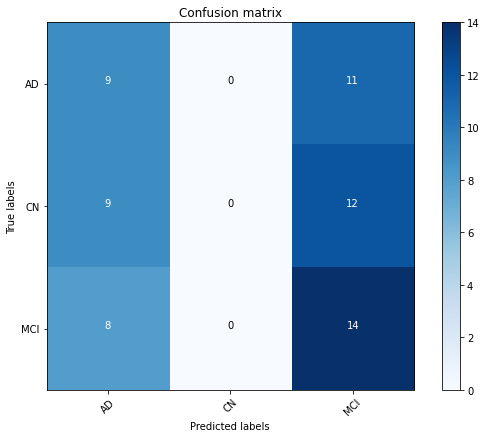

In [131]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

<!-- GoogLeNet 
ILSVRC-2013 (Clarifai)
MSRA
Zeler & Fergus
OverFeat
Krizhevsky -->

## Visualizar resultados del entrenamiento

print(model.history.history.keys())

In [132]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.38948154, 0.4712708, 0.5023395, 0.5188097, 0.5380872, 0.54164326, 0.5639154, 0.56447685, 0.5702789, 0.58974355, 0.57832676]
[0.343083, 0.3652174, 0.36205533, 0.34466404, 0.33517787, 0.3478261, 0.34150198, 0.3422925, 0.34703556, 0.3494071, 0.3486166]
[1.0854174167324981, 1.0451896293721528, 1.007478758098703, 0.9829072778242348, 0.9605190706079023, 0.9518638080076267, 0.9249609464923474, 0.9139183671782799, 0.9120821718551148, 0.8957089864536102, 0.8896338216111206]
[1.1184098809957503, 1.1354259222745895, 1.1956936463713645, 1.350765234231949, 1.4618200987577439, 1.517990881204605, 1.5751123279333115, 1.5856042563915254, 1.5071950525045394, 1.4455876737833022, 1.6248500257730485]


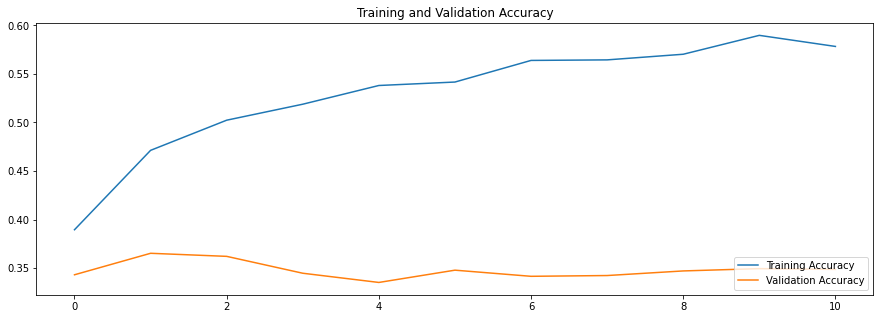

In [134]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(11)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

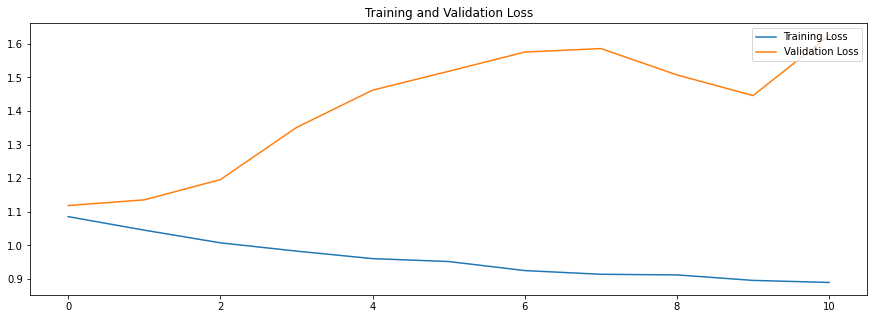

In [135]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [136]:
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.35      0.45      0.39        20
          CN       0.00      0.00      0.00        21
         MCI       0.38      0.64      0.47        22

    accuracy                           0.37        63
   macro avg       0.24      0.36      0.29        63
weighted avg       0.24      0.37      0.29        63



C:\ProgramData\Anaconda3\envs\gpu_tfm_unir\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\gpu_tfm_unir\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\envs\gpu_tfm_unir\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---
---
---

## Construccion y construir afinar el modelo CNN-Xception (Modelo afinado)

In [142]:
# Agregar la base de la parte superior del modelo (top)

nb_classes = 3

def add_top(base):
    x = base.output

    # Capa de grupo de promedio global
    x = GlobalAveragePooling2D()(x)

    x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.2)(x)
    
    # Capa regular densamente conectada
    x = Dense(512, activation='relu')(x)

    # Capa de salida
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs = base.input, outputs= predictions)

In [143]:
# Modelo de configuración afinado
def setup_model(model, trainable):
    # Congelar las capas no entrenables de la base del modelo
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Tasa de entrenamiento más lenta para el ajuste fino
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        # optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [144]:
# Configurar el modelo para volver a entrenar nuestra 
# capa superior más el bloque 13 y 14 de Xception
with tensorflow.device('DML'):
    xception_base = xception.Xception(include_top=False,
                                      weights='imagenet',
                                      input_shape=(img_width, img_height, 3))

    model = add_top(xception_base)
    model = setup_model(model, 19)

In [145]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_18[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# Afinar la modelo

epochs_ft = 20

with tensorflow.device('DML'):
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=10, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit_generator(train_batches,
                        epochs=epochs_ft,
                        validation_data=valid_batches,
                        verbose=2,
                        callbacks = [earlystopper])

Epoch 1/20
Epoch 1/20
167/167 - 142s - loss: 1.0994 - acc: 0.3358 - val_loss: 1.1172 - val_acc: 0.3257
Epoch 2/20
Epoch 1/20
167/167 - 125s - loss: 1.0967 - acc: 0.3498 - val_loss: 1.1080 - val_acc: 0.3304
Epoch 3/20
Epoch 1/20
167/167 - 125s - loss: 1.0953 - acc: 0.3567 - val_loss: 1.1017 - val_acc: 0.3407
Epoch 4/20


## Prediccion modelo afinado Xception model (Modelo afinado)

In [ ]:
predictions = model.predict(x=test_batches, verbose=0)

In [ ]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [ ]:
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento (Modelo afinado)

In [ ]:
print(model.history.history.keys())

In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

In [ ]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(epochs_ft)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

Como puede ver en los gráficos, la precisión del entrenamiento y la precisión de la validación están desfasadas por un amplio margen y el modelo ha logrado solo alrededor del 92 % de precisión en el conjunto de validación.

Veamos qué salió mal e intentemos aumentar el rendimiento general del modelo.

## Sobreajuste

En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 35 % en el proceso de entrenamiento. Además, la diferencia en la precisión entre la precisión del entrenamiento y la validación es notable, un signo de sobreajuste .

Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de los ruidos o detalles no deseados de los ejemplos de entrenamiento, hasta el punto de afectar negativamente el rendimiento del modelo en los nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

Hay múltiples formas de combatir el sobreajuste en el proceso de entrenamiento:

- Aumento de datos (aplicada)
- Aplicar giro horizontal (aplicada)
- Rotar aleatoriamente la imagen (aplicada)
- Aplicar aumento de zoom (aplicada)
- Dropout

## Dropout

técnica para reducir el sobreajuste es introducir deserción en la red. Es una forma de regularización que obliga a los pesos de la red a tomar solo valores pequeños, lo que hace que la distribución de los valores de peso sea más regular y la red puede reducir el sobreajuste en ejemplos de entrenamiento pequeños. Dropout es una de las técnicas de regularización utilizadas.

Cuando aplica abandono a una capa, elimina aleatoriamente (establecido en cero) un número de unidades de salida de la capa aplicada durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en forma de 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

Cuando se aplica un abandono de 0,1 a una determinada capa, elimina aleatoriamente el 10 % de las unidades de salida en cada época de entrenamiento.

### Creando una nueva red con Dropouts

Aquí, aplica el abandono a la primera y la última capa de agrupación máxima y a una capa completamente conectada que tiene 512 unidades de salida. El 30 % de la primera y la última capa de agrupación máxima, y ​​el 10 % de las unidades de salida de capa completamente conectadas, se establecen aleatoriamente en cero durante cada época de entrenamiento.

https://www.kaggle.com/code/voandy/transfer-learning-fine-tuning-xception-98-7-acc/script

https://colab.research.google.com/github/tensorflow/docs/blob/snapshot-keras/site/en/guide/keras/transfer_learning.ipynb#scrollTo=4235d0c69821

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/
https://learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Recall

https://androidkt.com/precision-recall-and-f1/

https://keras.io/api/preprocessing/image/

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-a-survey-265406fa542a

https://www.youtube.com/watch?v=3V9YFPfgyAY

https://github.com/Yale-Deep-Learning-for-Alzheimers/Alzheimers-DL-Network

https://www.kaggle.com/code/muneebkhurram/alzheimer-mri-classification

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

https://keras.io/api/applications/

https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/